In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

import torch
from torch import nn
from torch import optim

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)
seed1 = 3823692416320169261
torch.manual_seed(seed1)
#torch.manual_seed(2456895685847942102) for a different run

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.7.0+cu101
10.1


In [2]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 64), 
            nn.ReLU(), 
            nn.Linear(64, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [3]:
env = gym.make('Acrobot-v1')
env.seed(seed1)
s = env.reset()
pe = policy_estimator(env)
print(pe.predict(s))
print(pe.network(torch.FloatTensor(s)))

tensor([0.3879, 0.3075, 0.3046], grad_fn=<SoftmaxBackward>)
tensor([0.3879, 0.3075, 0.3046], grad_fn=<SoftmaxBackward>)


In [4]:
env.reset()

array([ 0.99865417,  0.05186381,  0.99947942, -0.03226291,  0.0430895 ,
       -0.00541356])

In [5]:
env.observation_space

Box(-28.274333953857422, 28.274333953857422, (6,), float32)

In [6]:
env.observation_space

Box(-28.274333953857422, 28.274333953857422, (6,), float32)

In [7]:
env.action_space.n

3

In [8]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

In [9]:
def reinforce(env, policy_estimator, num_episodes=3000,
              batch_size=10, gamma=0.99):

    # Set up lists to hold results
    total_rewards = []
    total_steps = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.005)
    
    action_space = np.arange(env.action_space.n)
    for ep in range(num_episodes):
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        step = 0
        complete = False
        while complete == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s_1, r, complete, _ = env.step(action)
            step = step + 1
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If complete, batch data
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                total_steps.append(step)
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    # print(state_tensor)
                    logprob = torch.log(
                        policy_estimator.predict(state_tensor))
                    # print(logprob)
                    selected_logprobs = reward_tensor * \
                        logprob[np.arange(len(action_tensor)), action_tensor]
                    # print(selected_logprobs)
                    loss = -selected_logprobs.mean()
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
                model = policy_estimator
                
    return model, total_rewards, total_steps

In [10]:
model, rewards, steps = reinforce(env, pe)

Ep: 3000 Average of last 10: -84.10

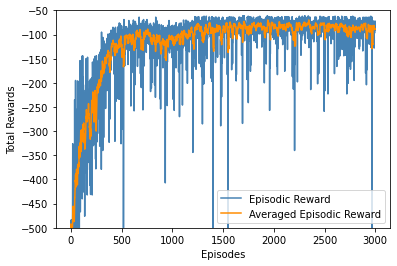

In [11]:

window = 10
averaged_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(6,4))
plt.plot(rewards,color='steelblue',label='Episodic Reward')
plt.plot(averaged_rewards,color='darkorange',label='Averaged Episodic Reward')
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')

plt.legend()
plt.legend.loc='best'
plt.ylim((-500,-50))
plt.show()

In [12]:
import random
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

Seed was: 702823032383545087


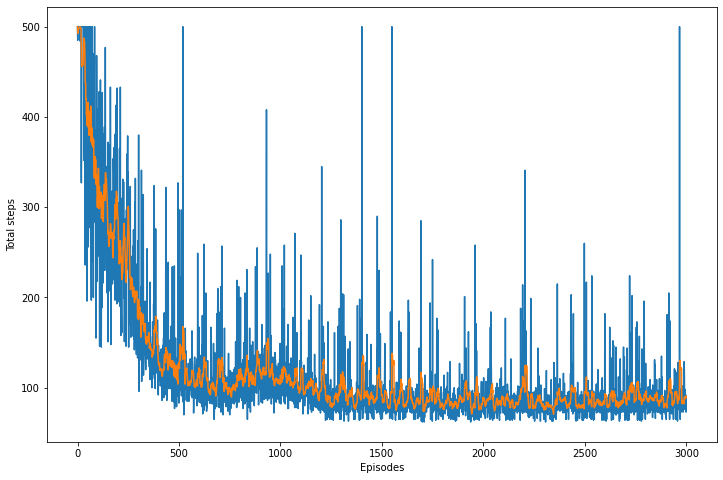

In [13]:
averaged_steps = [np.mean(steps[i-window:i+1]) if i > window 
                    else np.mean(steps[:i+1]) for i in range(len(steps))]

plt.figure(figsize=(12,8))
plt.plot(steps)
plt.plot(averaged_steps)
plt.ylabel('Total steps')
plt.xlabel('Episodes')
#plt.title('learning rate=0.005,#hidden nodes=64')
#plt.legend('episodic reward','averaged episodic reward')
plt.show()

In [14]:
np.mean(rewards)

-118.58066666666667

In [15]:
np.std(rewards)

80.58736559094663

In [16]:
def reinforce_test(env, policy_estimator, num_episodes=1000,
              batch_size=10, gamma=0.99):

    # Set up lists to hold results
    total_rewards = []
    total_steps = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.005)
    
    action_space = np.arange(env.action_space.n)
    for ep in range(num_episodes):
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        step = 0
        complete = False
        while complete == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s_1, r, complete, _ = env.step(action)
            step = step + 1
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If complete, batch data
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                total_steps.append(step)
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(
                        policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * \
                        logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = -selected_logprobs.mean()
                    

                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
                model = policy_estimator
                
    return  total_rewards, total_steps

Ep: 1000 Average of last 10: -80.20

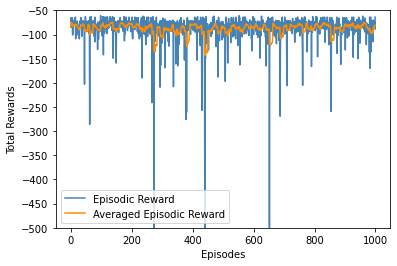

In [17]:
rewards, steps = reinforce_test(env, model)
window = 10
averaged_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

# plt.figure(figsize=(12,8))
plt.plot(rewards,color='steelblue',label='Episodic Reward')
plt.plot(averaged_rewards,color='darkorange',label='Averaged Episodic Reward')
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')

plt.legend()
plt.legend.loc='best'
plt.ylim((-500,-50))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/lo

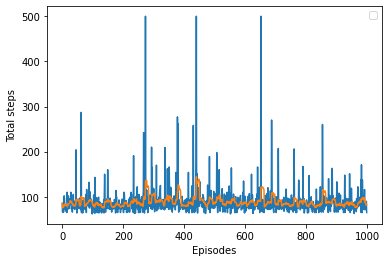

In [18]:
averaged_steps = [np.mean(steps[i-window:i+1]) if i > window 
                    else np.mean(steps[:i+1]) for i in range(len(steps))]

# plt.figure()
plt.plot(steps)
plt.plot(averaged_steps)
plt.ylabel('Total steps')
plt.xlabel('Episodes')
#plt.title('learning rate=0.005,#hidden nodes=64')
plt.legend('episodic reward','averaged episodic reward')
plt.show()

In [19]:
np.mean(rewards)

-87.837

In [20]:
np.std(rewards)

33.77757289978071